In [111]:
import pandas as pd
import minsearch_xtra as minsearch
import os
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
from openai import OpenAI
import json
from tqdm.auto import tqdm
import pickle
from concurrent.futures import ThreadPoolExecutor
from openai import OpenAI
import json
from sentence_transformers import SentenceTransformer

In [55]:
df = pd.read_csv("../data/stoic_zen_document.csv")
df.insert(0,'id',df.index)

documents = df.to_dict(orient="records")
print("lenght of the documents:", len(documents))

index = minsearch.Index(
    text_fields=["category", "question", "answer"],
    keyword_fields=['id',"ideology"]
)

index.fit(documents)

lenght of the documents: 820


In [58]:
def minsearch_improved(query,ideology):
    boost = {
        'question': 1.22,
        'category': 0.36
    }

    results = index.search(
        query=query,
        filter_dict={'ideology': ideology},
        boost_dict=boost,
        num_results=5
    )

    return results

def build_prompt(query, search_results):
    prompt_template = """
    You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.
    
    QUESTION: {question}
    
    CONTEXT: 
    {context}
    """.strip()

    context = ""
    
    for doc in search_results:
        context = context + f"category: {doc['category']}\nquestion: {doc['question']}\nanswer: {doc['answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt


client = OpenAI()

def llm(prompt, model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o-mini') -> str:
    search_results = minsearch_improved(query['question'],query['ideology'])
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

### Create llm answers to ground truth data

In [62]:
df_gt = pd.read_csv("../data/ground_truth_retrieval.csv")
ground_truth = df_gt.to_dict(orient='records')

ground_truth_w_answers = {}

for id, rec in enumerate(tqdm(ground_truth)):
    llm_answer = rag(rec)
    
    idx = ground_truth[id]["id"]
    # Filter for entries with a specific id, e.g., id = 1
    filtered_data = [entry for entry in documents if entry['id'] == idx]
    original_answer = filtered_data[0]["answer"]

    ground_truth_w_answers[id] = {
        "question": rec["question"],
        "ideology": rec["ideology"],
        "llm_answer": llm_answer,
        "original_answer": original_answer
    }

  0%|          | 0/4100 [00:00<?, ?it/s]

In [74]:
with open('ground_truth_w_answers.json', 'w') as json_file:
    json.dump(ground_truth_w_answers, json_file, indent=4)

df_gpt4o = pd.DataFrame.from_dict(ground_truth_w_answers, orient='index')
df_gpt4o.to_csv('../data/results-gpt4o.csv', index=False)

# Cosine Similarity

In [86]:
df_gpt4o = pd.read_csv("../data/results-gpt4o.csv")
results_gpt4o = df_gpt4o.to_dict(orient='records')

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

def compute_similarity(record):
    answer_orig = record['original_answer']
    answer_llm = record['llm_answer']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/4100 [00:00<?, ?it/s]

In [112]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    4100.000000
mean        0.815537
std         0.126314
min         0.100687
25%         0.749605
50%         0.840572
75%         0.908356
max         1.000000
Name: cosine, dtype: float64

In [110]:
# save output
df_gpt4o.to_csv('../data/results-gpt4o-mini-cosine.csv', index=False)

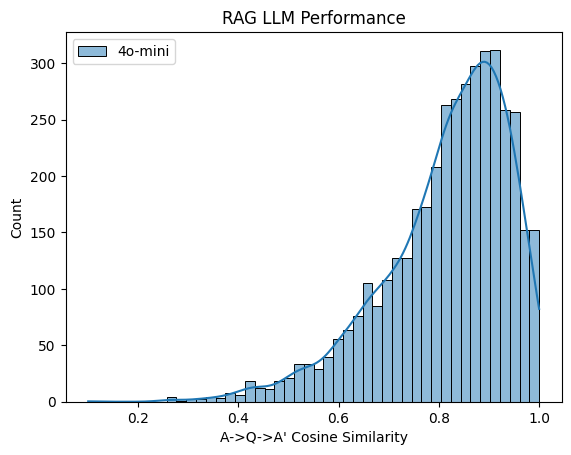

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Updated to use sns.histplot
sns.histplot(df_gpt4o['cosine'], label='4o-mini', kde=True)

plt.title("RAG LLM Performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

plt.show()

# LLM as a Judge

In [90]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {original_answer}
Generated Question: {question}
Generated Answer: {llm_answer}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {llm_answer}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [94]:
df_sample = df_gpt4o.sample(n=150, random_state=1)
samples = df_sample.to_dict(orient='records')

### answer -> question -> answer evaluation

In [95]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

# Convert JSON strings to Python dictionaries
evaluations_dicts = [json.loads(item) for item in evaluations]

  0%|          | 0/150 [00:00<?, ?it/s]

In [102]:
# Convert list of dictionaries into a pandas DataFrame
df_aqa = pd.DataFrame(evaluations_dicts)
df_aqa[df_aqa.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
115,NON_RELEVANT,The generated answer does not address the orig...


### question -> answer evaluation

In [101]:
evaluations_qa = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_qa.append(evaluation)

# Convert JSON strings to Python dictionaries
evaluations_qa_dicts = [json.loads(item) for item in evaluations_qa]

  0%|          | 0/150 [00:00<?, ?it/s]

In [105]:
# Convert list of dictionaries into a pandas DataFrame
df_qa = pd.DataFrame(evaluations_qa_dicts)
df_qa[df_qa.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
18,NON_RELEVANT,The generated answer states that Medieval Chri...
37,NON_RELEVANT,The generated answer provides 'distress' as an...
115,NON_RELEVANT,The generated answer fails to address the ques...
127,NON_RELEVANT,The generated answer does not address the ques...
135,NON_RELEVANT,The generated answer does not specify any actu...
